In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import shutil
import pandas as pd
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip drive/MyDrive/train_118.zip -d content/
!unzip drive/MyDrive/test_prof_2.zip -d content/

Streaming output truncated to the last 5000 lines.
  inflating: content/train/M_58632.png  
  inflating: content/train/M_58633.png  
  inflating: content/train/M_58634.png  
  inflating: content/train/M_58635.png  
  inflating: content/train/M_58636.png  
  inflating: content/train/M_58637.png  
  inflating: content/train/M_58638.png  
  inflating: content/train/M_58639.png  
  inflating: content/train/M_5864.png  
  inflating: content/train/M_58640.png  
  inflating: content/train/M_58641.png  
  inflating: content/train/M_58642.png  
  inflating: content/train/M_58643.png  
  inflating: content/train/M_58644.png  
  inflating: content/train/M_58645.png  
  inflating: content/train/M_58646.png  
  inflating: content/train/M_58647.png  
  inflating: content/train/M_58648.png  
  inflating: content/train/M_58649.png  
  inflating: content/train/M_5865.png  
  inflating: content/train/M_58650.png  
  inflating: content/train/M_58651.png  
  inflating: content/train/M_58652.png  
  inflat

In [ ]:
PATH_TEST_PROF = os.path.join(os.getcwd(), 'content', 'test_prof_2')
img_list = os.listdir(PATH_TEST_PROF)

dataset_test_prof_x = []
dataset_test_prof_y = []

for path in img_list:
  img = cv.imread(os.path.join(PATH_TEST_PROF, path), 0)
  img = img/255.0
  dataset_test_prof_x.append(img)
  dataset_test_prof_y.append(0 if path[0] == 'F' else 1)

dataset_test_prof_x = np.asarray(dataset_test_prof_x, dtype='float32')
dataset_test_prof_y = np.asarray(dataset_test_prof_y, dtype='uint8')

In [ ]:
PATH_TRAIN = os.path.join(os.getcwd(), 'content', 'train')
img_list = os.listdir(PATH_TRAIN)
len(img_list)

def get_label(img):
  img_name = img.numpy().decode("utf-8")[len(PATH_TRAIN) + 1:]
  return tf.convert_to_tensor([0 if img_name.split('_')[0] == 'F' else 1])

def get_img_path(img):
  return os.path.join(PATH_TRAIN, img)

IMG_PATHS = list(map(get_img_path, img_list))

IMG_PATHS = tf.convert_to_tensor(IMG_PATHS)
IMG_DATASET = tf.data.Dataset.from_tensor_slices(IMG_PATHS)
DATASET_SIZE = IMG_DATASET.cardinality().numpy()

print("Total Images : ", len(IMG_PATHS))

Total Images :  118000


In [ ]:
def combine_images_labels(file_path: tf.Tensor):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_png(img, channels=1)
  img = tf.image.convert_image_dtype(img, dtype=tf.float32)
  label = get_label(file_path)
  return img,label

In [ ]:
TRAIN_RATIO = 0.80

dataset_train = IMG_DATASET.take(DATASET_SIZE * TRAIN_RATIO)
dataset_test = IMG_DATASET.skip(DATASET_SIZE * TRAIN_RATIO)

print("Train size : ", dataset_train.cardinality().numpy())
print("Test Size  : ", dataset_test.cardinality().numpy())

Train size :  94400
Test Size  :  23600


In [ ]:
dataset_train = dataset_train.map(lambda x:tf.py_function(func=combine_images_labels, inp=[x], Tout=(tf.float32, tf.int32)), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

dataset_train.prefetch(DATASET_SIZE - (DATASET_SIZE*TRAIN_RATIO))

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

In [ ]:
dataset_test = dataset_test.map(lambda x:tf.py_function(func=combine_images_labels, inp=[x], Tout=(tf.float32, tf.int32)), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
dataset_test.prefetch(DATASET_SIZE - (DATASET_SIZE*TRAIN_RATIO))

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

In [ ]:
for img, label in dataset_train.take(1):
  print("Image Shape : ", img.shape)
  print("Label : ", label.numpy())

Image Shape :  (128, 128, 1)
Label :  [0]


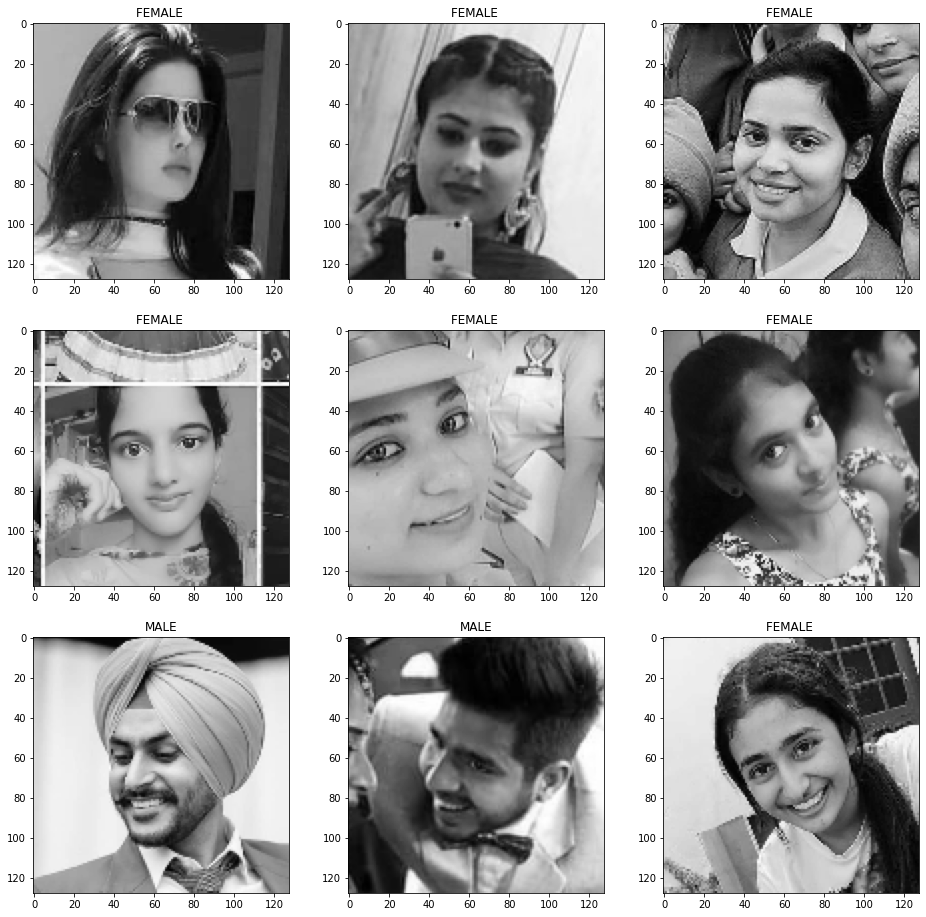

In [ ]:
def show_samples(dataset):
  fig = plt.figure(figsize=(16,16))
  columns = 3
  rows = 3
  i = 1
  for a,b in dataset.take(columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(a), cmap='gray')
    plt.title('FEMALE ' if b.numpy() == 0 else 'MALE')
    i += 1
  plt.show()
show_samples(dataset_train)

In [ ]:
def _fixup_shape(img, label):
  img.set_shape([None, None, None, 1])
  label.set_shape([None, 1])
  return img, label

In [ ]:
BATCH_SIZE = 32

dataset_train_batched = dataset_train.batch(BATCH_SIZE).map(_fixup_shape).cache().prefetch(tf.data.experimental.AUTOTUNE)
dataset_test_batched = dataset_test.batch(BATCH_SIZE).map(_fixup_shape).cache().prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
print("Number of batches in train : ", dataset_train_batched.cardinality().numpy())
print("Number of batches in test  : ", dataset_test_batched.cardinality().numpy())

Number of batches in train :  2950
Number of batches in test  :  738


In [ ]:
class real_time_callback(tf.keras.callbacks.Callback):

    def __init__(self):
        super().__init__()
        self.loss_list = []
        self.val_loss = []
        self.acc_list = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs={}): 
      self.loss_list.append(logs.get('loss'))
      self.val_loss.append(logs.get('val_loss'))
      self.acc_list.append(logs.get('accuracy'))
      self.val_acc.append(logs.get('val_accuracy'))

      fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

      ax1.plot(self.loss_list, label="train")
      ax1.plot(self.val_loss, label="validation")
      ax1.legend(loc="upper left")

      ax2.plot(self.acc_list)
      ax2.plot(self.val_acc)

      plt.show()

**Data Loader**

In [ ]:
def feat_ex_block(input_layer, num_filter_1, conv_2_b_k_s, count=1):
  assert (count >= 1)
  """
  Parameters:
    input_layer  = previous layer of the model
    num_filter_1 = number of filters in first convolutional layer
    conv_2_b_k_s = size of conv_2_b kernel
    count        = number of FEAT_EX blocks to consider (default 1) 
  Return:
    maxpooled_layer after all FEAT_EX blocks.
  """
  FEAT_EX_NUM_FILTER_A = num_filter_1 + 32
  FEAT_EX_NUM_FILTER_B = FEAT_EX_NUM_FILTER_A * 2 + 16
  FEAT_EX_NUM_FILTER_C = num_filter_1

  FEAT_EX_FILTER_SIZE_A = 1
  FEAT_EX_FILTER_SIZE_B = conv_2_b_k_s
  FEAT_EX_FILTER_SIZE_C = 1

  conv_a     = keras.layers.Conv2D(filters=FEAT_EX_NUM_FILTER_A, kernel_size=(FEAT_EX_FILTER_SIZE_A, FEAT_EX_FILTER_SIZE_A), strides=(1,1), padding='same', activation=tf.nn.relu)(input_layer)
  conv_b     = keras.layers.Conv2D(filters=FEAT_EX_NUM_FILTER_B, kernel_size=(FEAT_EX_FILTER_SIZE_B, FEAT_EX_FILTER_SIZE_B), strides=(1,1), padding='same', activation=tf.nn.relu)(conv_a)

  maxpool_a  = keras.layers.MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(input_layer)
  conv_c     = keras.layers.Conv2D(filters=FEAT_EX_NUM_FILTER_C, kernel_size=(FEAT_EX_FILTER_SIZE_C, FEAT_EX_FILTER_SIZE_C), strides=(1,1))(maxpool_a)

  concat_2     = tf.keras.layers.concatenate(inputs=[conv_b , conv_c], axis=3)
  maxpool_b  = keras.layers.MaxPooling2D(pool_size=(2,2))(concat_2)
  if count == 1:
    return maxpool_b
  else :
    return feat_ex_block(maxpool_b, num_filter_1, conv_2_b_k_s,count-1)

def train_model(Conv_1_f_n, Conv_1_k_s, Conv_2_b_k_s):

  IMG_SIZE = 128
  NUM_CLASSES = 2
  NUM_FILTER_1 = Conv_1_f_n
  FILTER_SIZE_1 = Conv_1_k_s

  img_input = keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE,1))

  # MODEL SATRT
  conv_1       = keras.layers.Conv2D(filters=NUM_FILTER_1, kernel_size=(FILTER_SIZE_1, FILTER_SIZE_1), strides=(2, 2),padding='same', activation=tf.nn.relu)(img_input)
  maxpool_1    = keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)
  normalized_1 = tf.keras.layers.BatchNormalization()(maxpool_1)

  feat_feed = feat_ex_block(normalized_1, NUM_FILTER_1, Conv_2_b_k_s, 2)

  # FINAL LAYER
  net = tf.keras.layers.Flatten()(feat_feed)
  net = tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')(net)

  model = tf.keras.Model(img_input, net)

  print(model.summary())
  
  return model


In [ ]:
model = train_model(64, 5, 3)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   1664        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

Epoch 1/50
2950/2950 [==============================] - 296s 89ms/step - loss: 0.3709 - accuracy: 0.8391 - val_loss: 0.1850 - val_accuracy: 0.9292


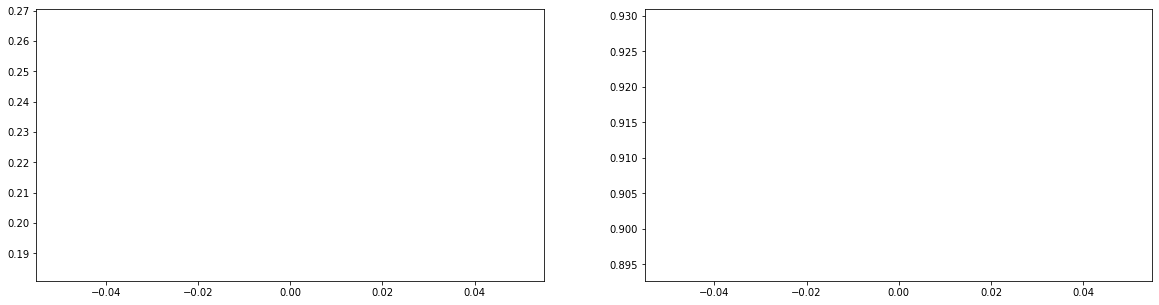

Epoch 2/50
2950/2950 [==============================] - 64s 22ms/step - loss: 0.1615 - accuracy: 0.9398 - val_loss: 0.1410 - val_accuracy: 0.9485


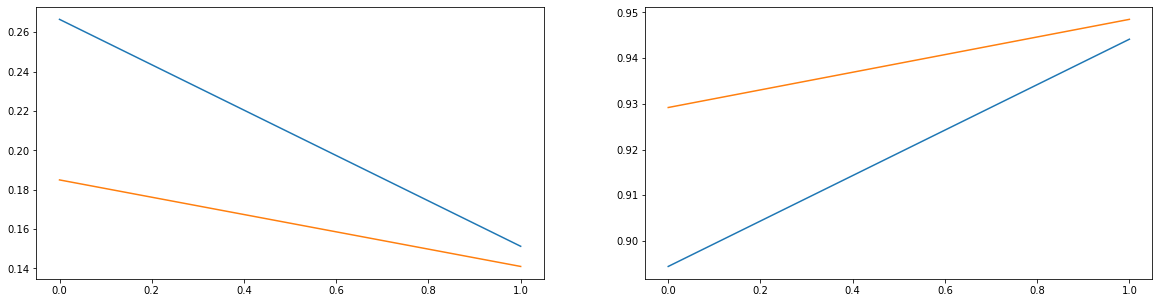

Epoch 3/50
2950/2950 [==============================] - 63s 21ms/step - loss: 0.1257 - accuracy: 0.9543 - val_loss: 0.1195 - val_accuracy: 0.9565


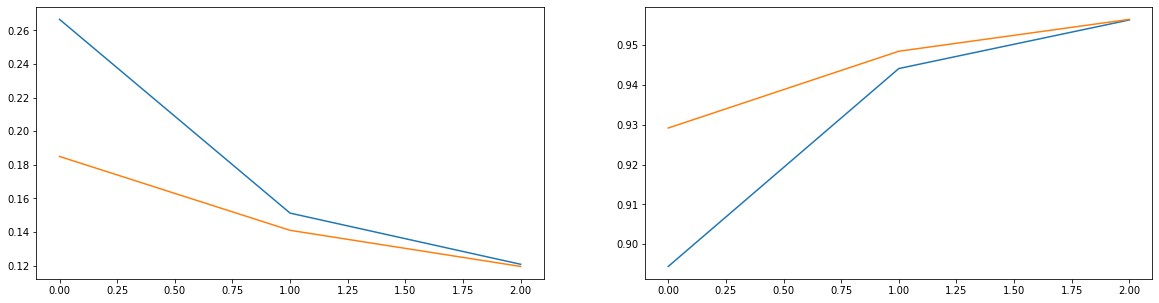

Epoch 4/50
2950/2950 [==============================] - 63s 21ms/step - loss: 0.1059 - accuracy: 0.9619 - val_loss: 0.1056 - val_accuracy: 0.9625


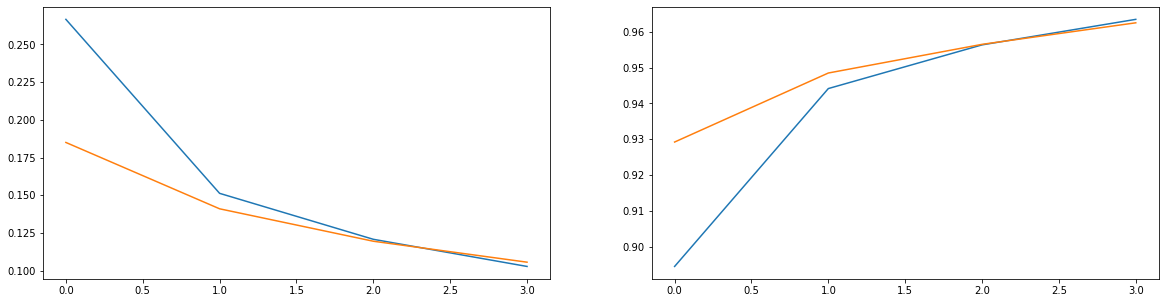

Epoch 5/50
2950/2950 [==============================] - 64s 22ms/step - loss: 0.0922 - accuracy: 0.9676 - val_loss: 0.0960 - val_accuracy: 0.9661


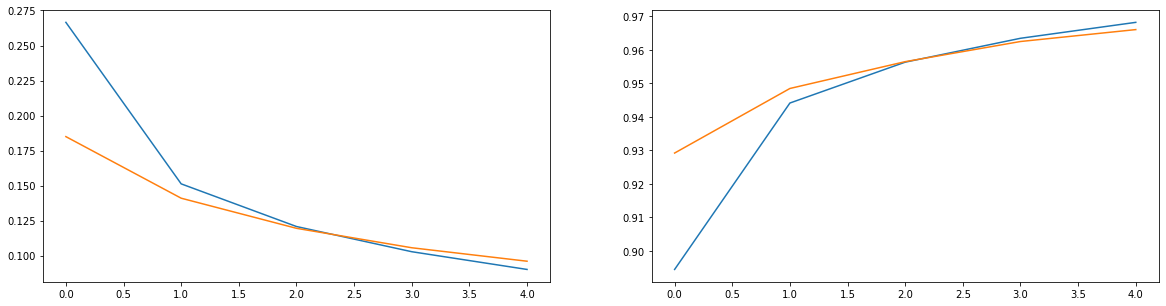

Epoch 6/50
2950/2950 [==============================] - 64s 22ms/step - loss: 0.0821 - accuracy: 0.9718 - val_loss: 0.0890 - val_accuracy: 0.9690


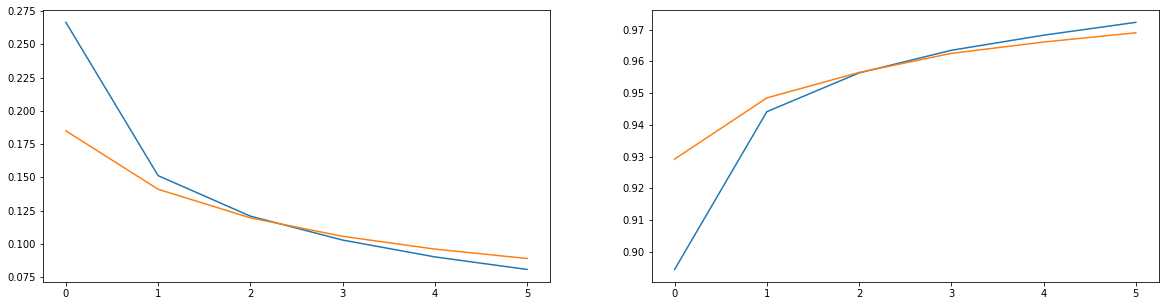

Epoch 7/50
2950/2950 [==============================] - 64s 22ms/step - loss: 0.0743 - accuracy: 0.9743 - val_loss: 0.0836 - val_accuracy: 0.9707


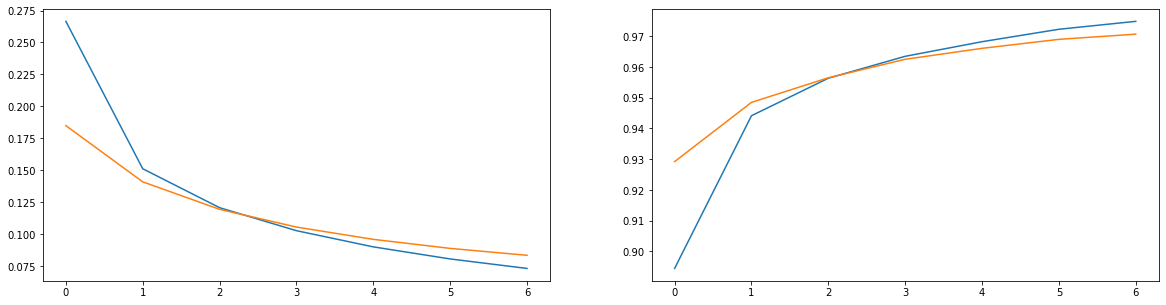

Epoch 8/50
2950/2950 [==============================] - 64s 22ms/step - loss: 0.0680 - accuracy: 0.9763 - val_loss: 0.0793 - val_accuracy: 0.9720


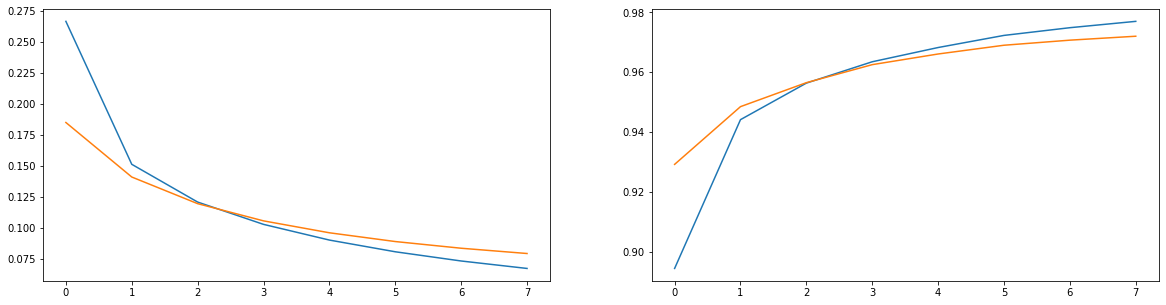

Epoch 9/50
2950/2950 [==============================] - 65s 22ms/step - loss: 0.0628 - accuracy: 0.9787 - val_loss: 0.0759 - val_accuracy: 0.9731


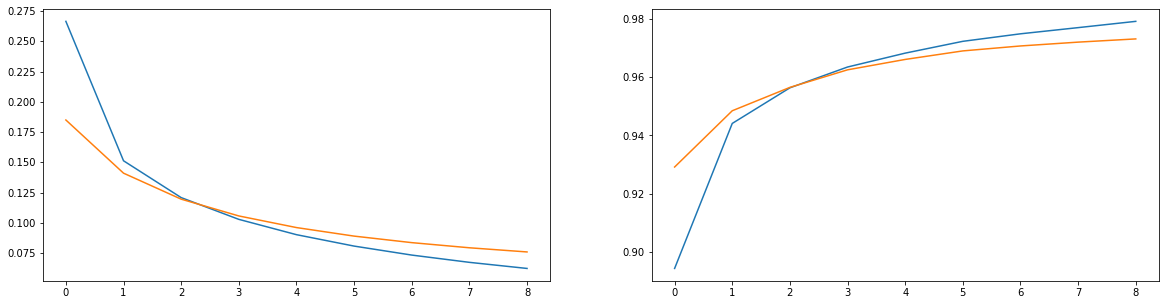

Epoch 10/50
2950/2950 [==============================] - 65s 22ms/step - loss: 0.0583 - accuracy: 0.9802 - val_loss: 0.0732 - val_accuracy: 0.9738


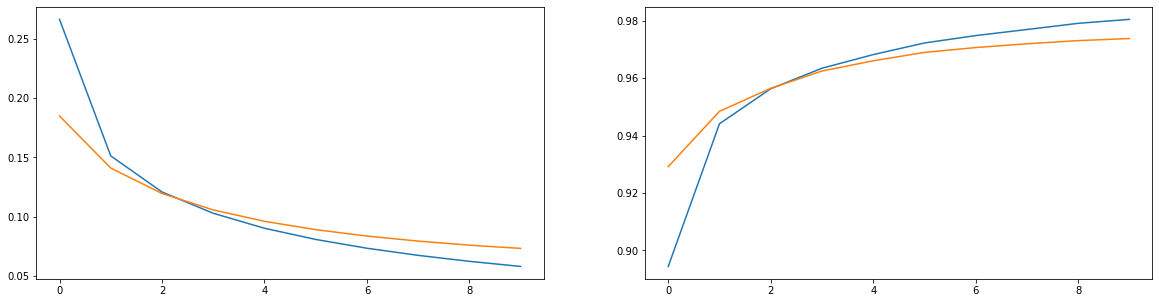

Epoch 11/50
2950/2950 [==============================] - 65s 22ms/step - loss: 0.0545 - accuracy: 0.9816 - val_loss: 0.0709 - val_accuracy: 0.9749


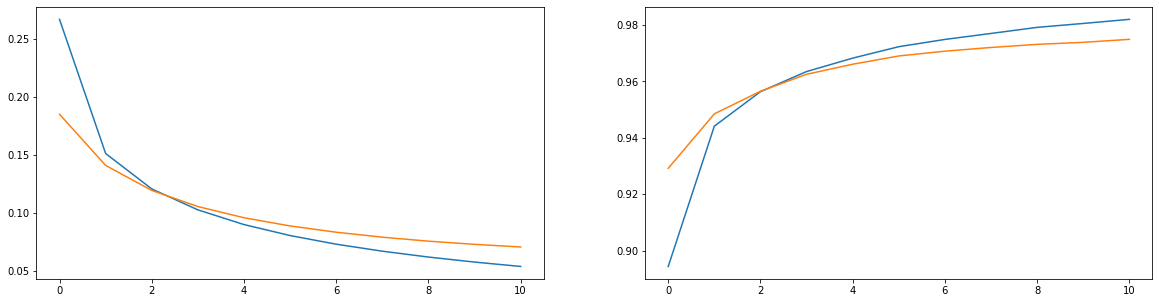

Epoch 12/50
2950/2950 [==============================] - 65s 22ms/step - loss: 0.0510 - accuracy: 0.9827 - val_loss: 0.0690 - val_accuracy: 0.9759


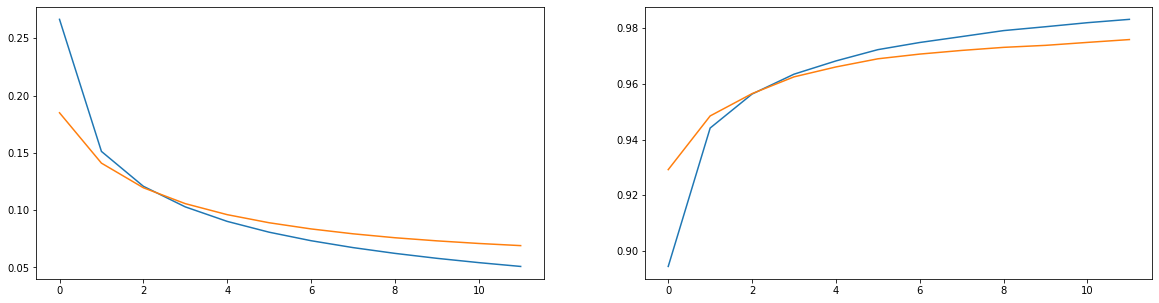

Epoch 13/50
2950/2950 [==============================] - 64s 22ms/step - loss: 0.0480 - accuracy: 0.9838 - val_loss: 0.0674 - val_accuracy: 0.9765


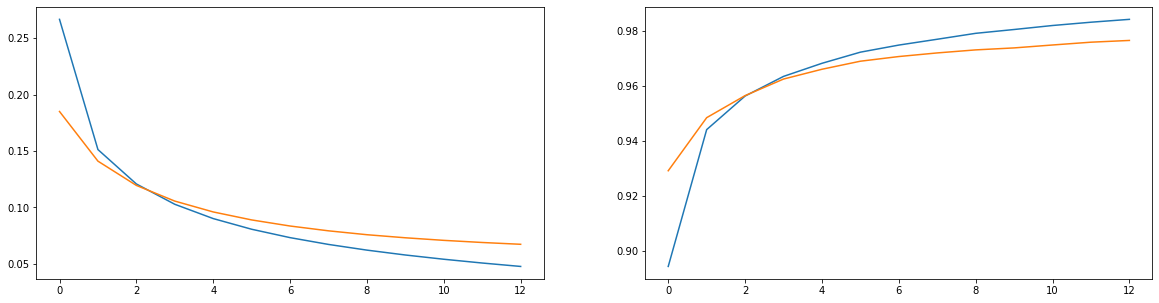

Epoch 14/50
2950/2950 [==============================] - 65s 22ms/step - loss: 0.0452 - accuracy: 0.9849 - val_loss: 0.0661 - val_accuracy: 0.9769


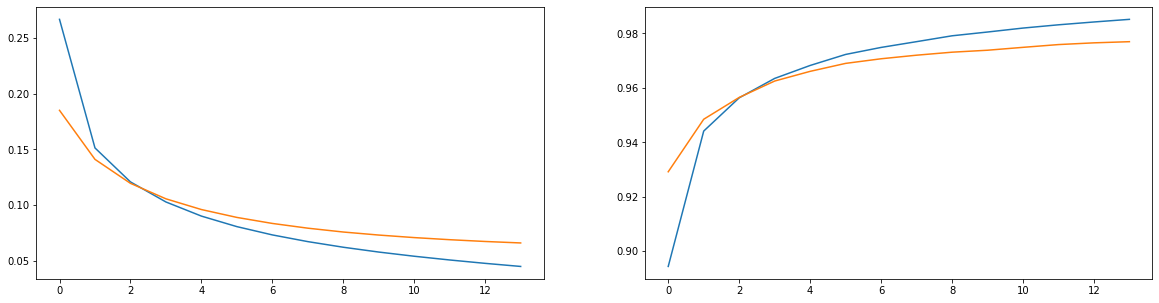

Epoch 15/50
2950/2950 [==============================] - 65s 22ms/step - loss: 0.0426 - accuracy: 0.9859 - val_loss: 0.0649 - val_accuracy: 0.9775


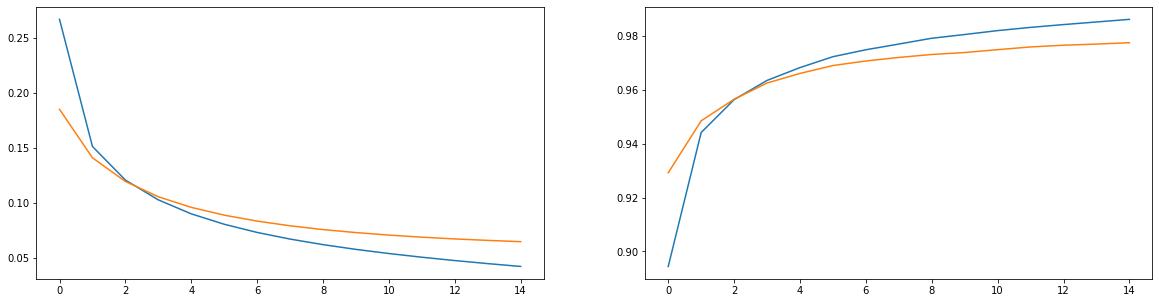

Epoch 16/50
2950/2950 [==============================] - 65s 22ms/step - loss: 0.0402 - accuracy: 0.9870 - val_loss: 0.0639 - val_accuracy: 0.9781


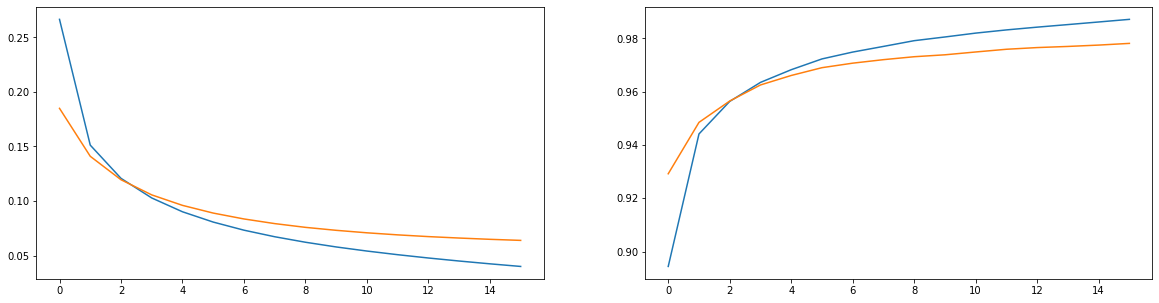

Epoch 17/50
2950/2950 [==============================] - 65s 22ms/step - loss: 0.0379 - accuracy: 0.9879 - val_loss: 0.0631 - val_accuracy: 0.9784


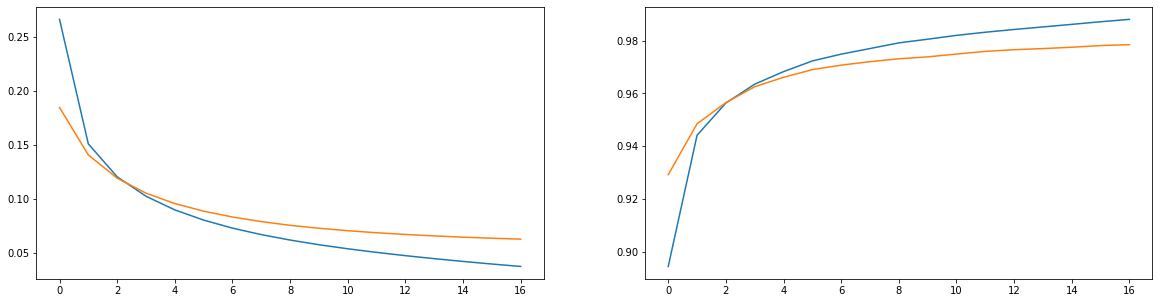

Epoch 18/50
2950/2950 [==============================] - 65s 22ms/step - loss: 0.0358 - accuracy: 0.9885 - val_loss: 0.0623 - val_accuracy: 0.9784


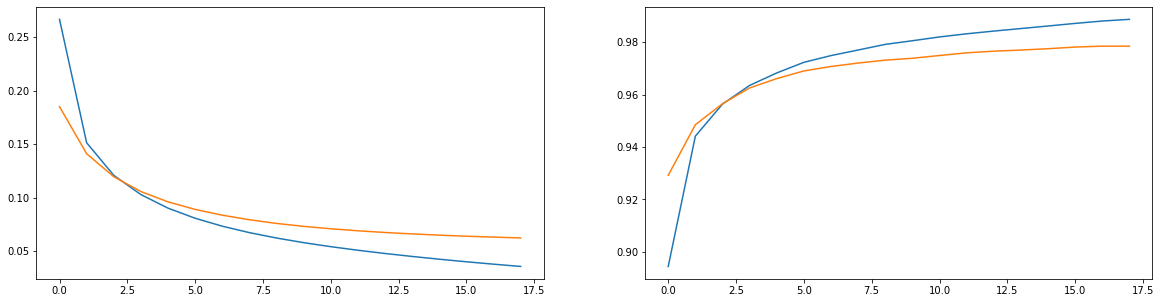

Epoch 19/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0338 - accuracy: 0.9893 - val_loss: 0.0617 - val_accuracy: 0.9789


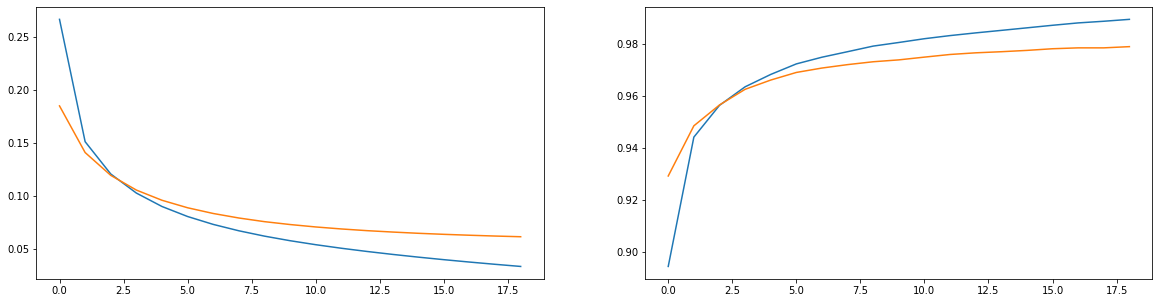

Epoch 20/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0318 - accuracy: 0.9902 - val_loss: 0.0611 - val_accuracy: 0.9792


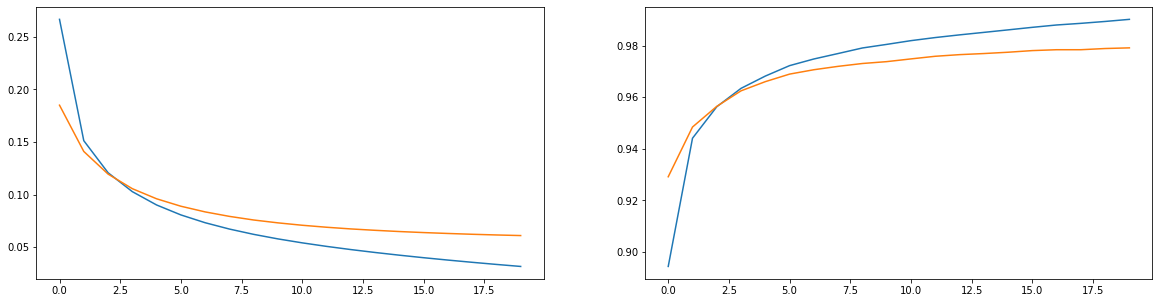

Epoch 21/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0300 - accuracy: 0.9909 - val_loss: 0.0607 - val_accuracy: 0.9794


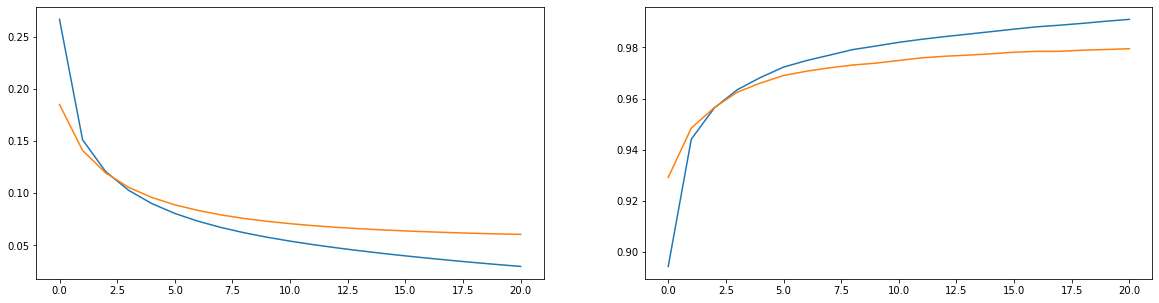

Epoch 22/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0283 - accuracy: 0.9916 - val_loss: 0.0603 - val_accuracy: 0.9796


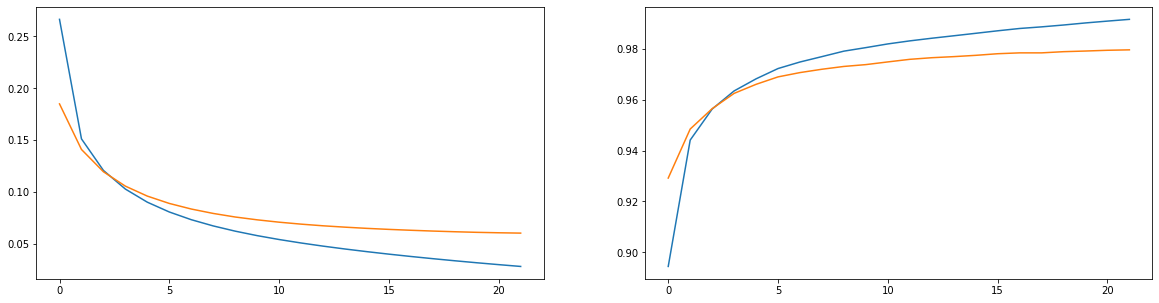

Epoch 23/50
2950/2950 [==============================] - 65s 22ms/step - loss: 0.0266 - accuracy: 0.9923 - val_loss: 0.0600 - val_accuracy: 0.9797


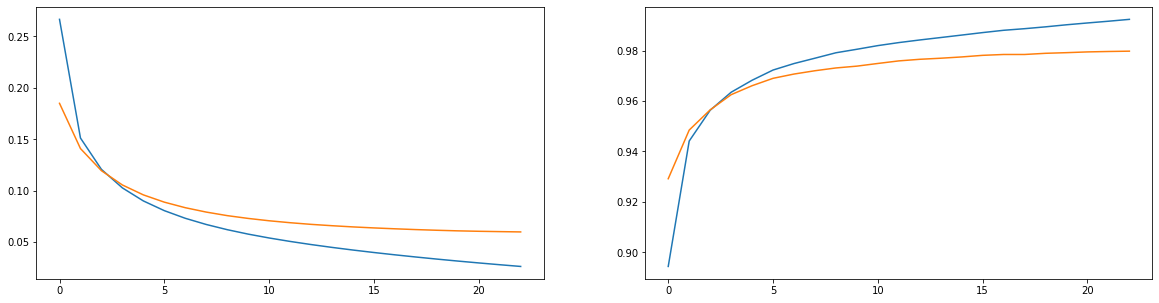

Epoch 24/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0250 - accuracy: 0.9931 - val_loss: 0.0598 - val_accuracy: 0.9798


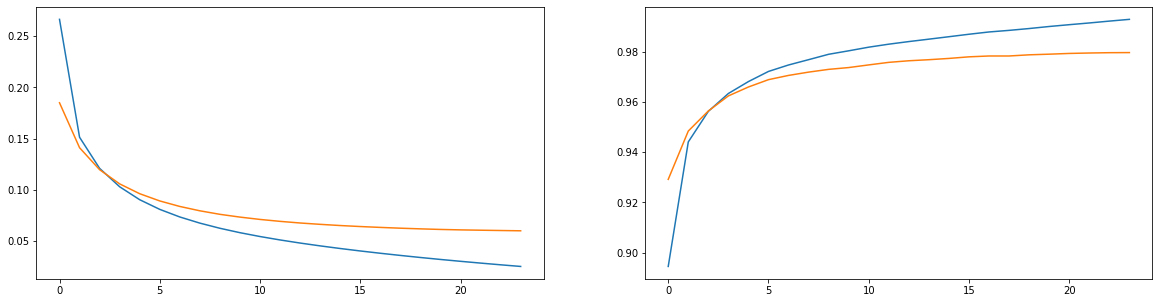

Epoch 25/50
2950/2950 [==============================] - 65s 22ms/step - loss: 0.0235 - accuracy: 0.9936 - val_loss: 0.0596 - val_accuracy: 0.9800


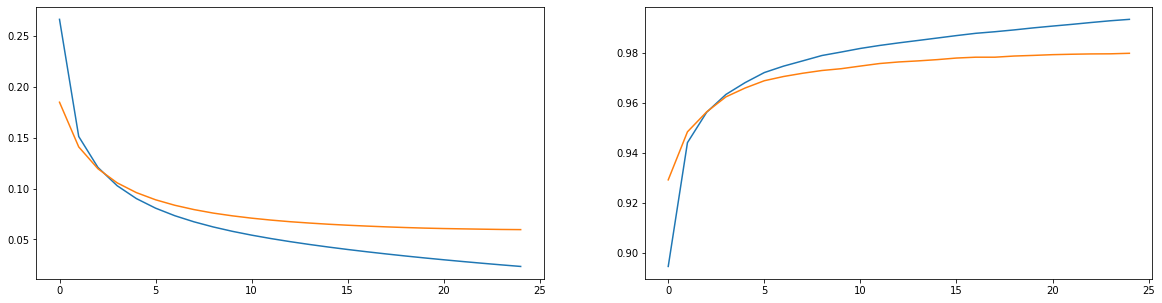

Epoch 26/50
2950/2950 [==============================] - 65s 22ms/step - loss: 0.0221 - accuracy: 0.9943 - val_loss: 0.0595 - val_accuracy: 0.9798


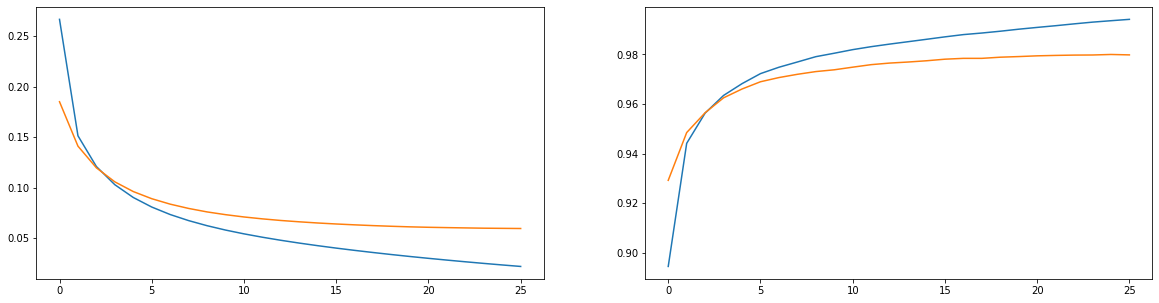

Epoch 27/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0207 - accuracy: 0.9947 - val_loss: 0.0595 - val_accuracy: 0.9802


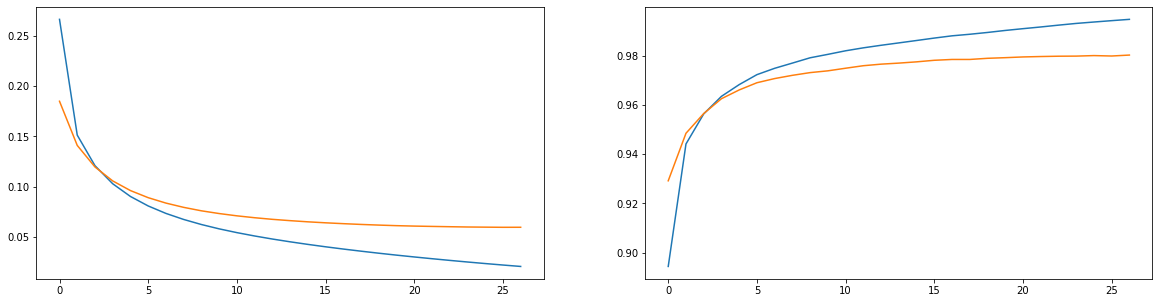

Epoch 28/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0193 - accuracy: 0.9953 - val_loss: 0.0596 - val_accuracy: 0.9803


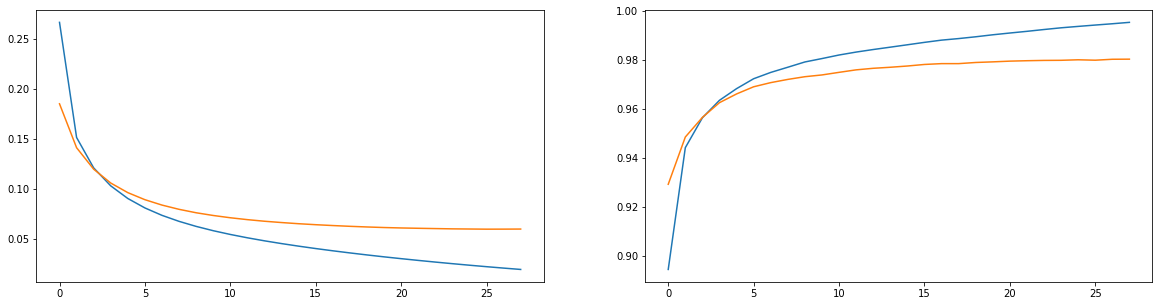

Epoch 29/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0180 - accuracy: 0.9957 - val_loss: 0.0597 - val_accuracy: 0.9803


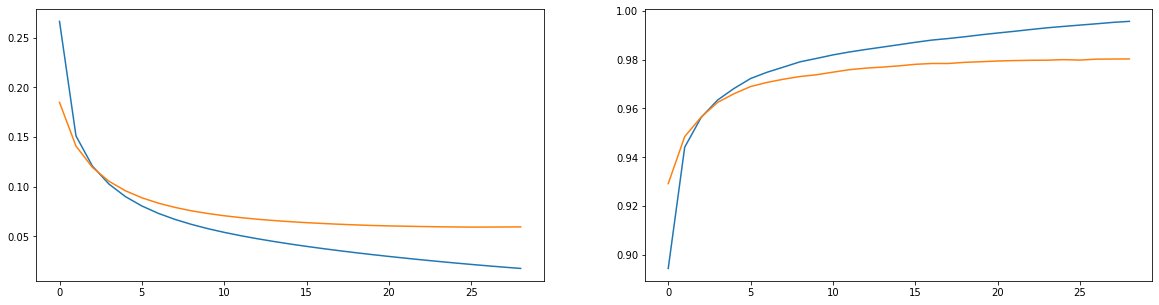

Epoch 30/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0168 - accuracy: 0.9961 - val_loss: 0.0599 - val_accuracy: 0.9805


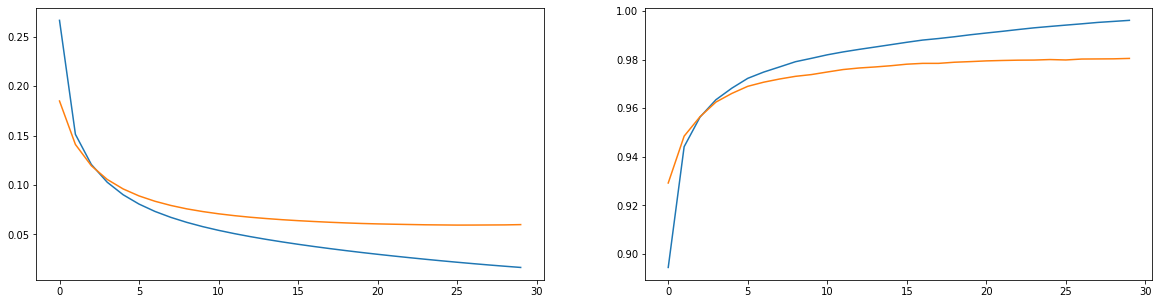

Epoch 31/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0157 - accuracy: 0.9967 - val_loss: 0.0603 - val_accuracy: 0.9805


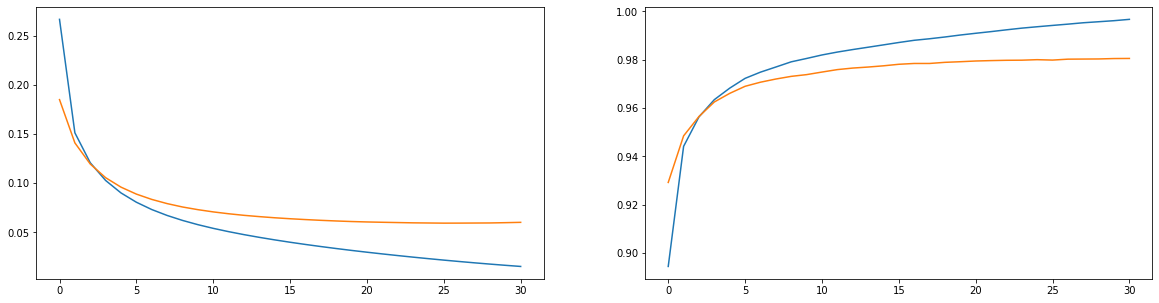

Epoch 32/50
2950/2950 [==============================] - 66s 23ms/step - loss: 0.0146 - accuracy: 0.9971 - val_loss: 0.0607 - val_accuracy: 0.9804


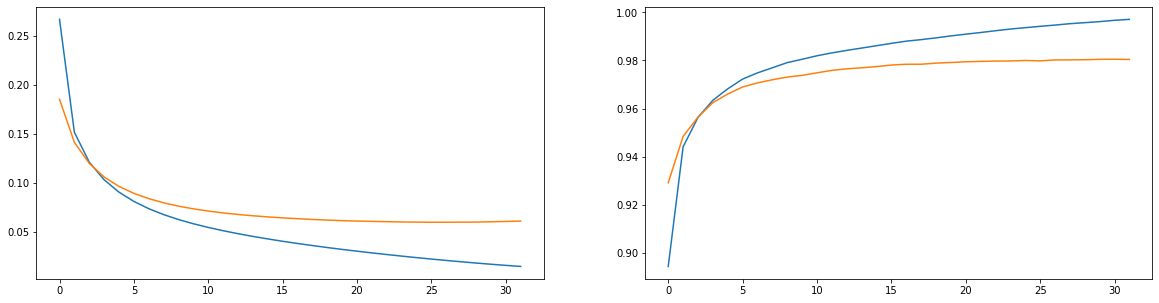

Epoch 33/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0135 - accuracy: 0.9974 - val_loss: 0.0610 - val_accuracy: 0.9805


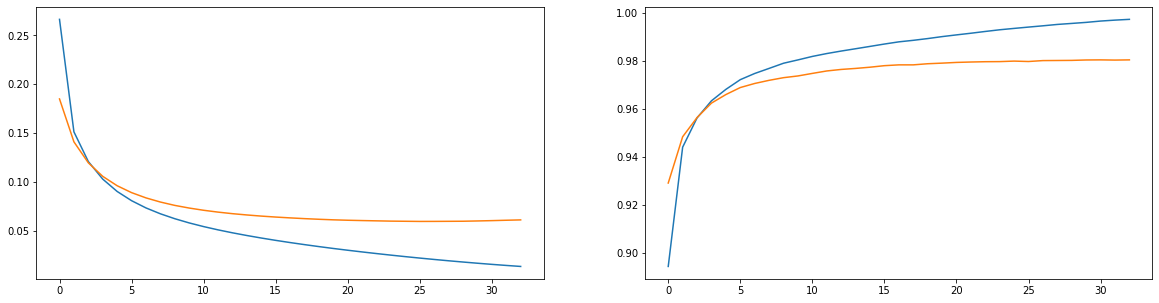

Epoch 34/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0126 - accuracy: 0.9978 - val_loss: 0.0614 - val_accuracy: 0.9804


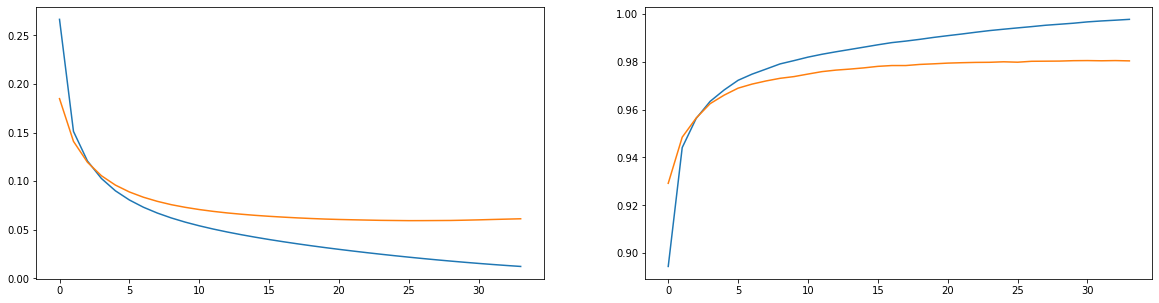

Epoch 35/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0116 - accuracy: 0.9980 - val_loss: 0.0618 - val_accuracy: 0.9804


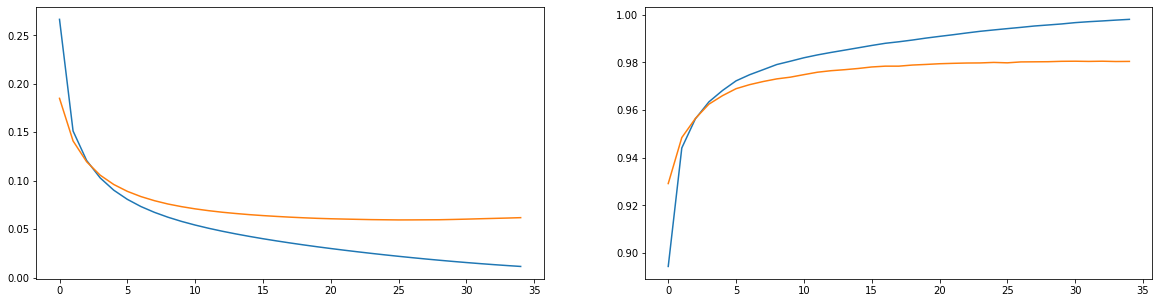

Epoch 36/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0108 - accuracy: 0.9983 - val_loss: 0.0622 - val_accuracy: 0.9803


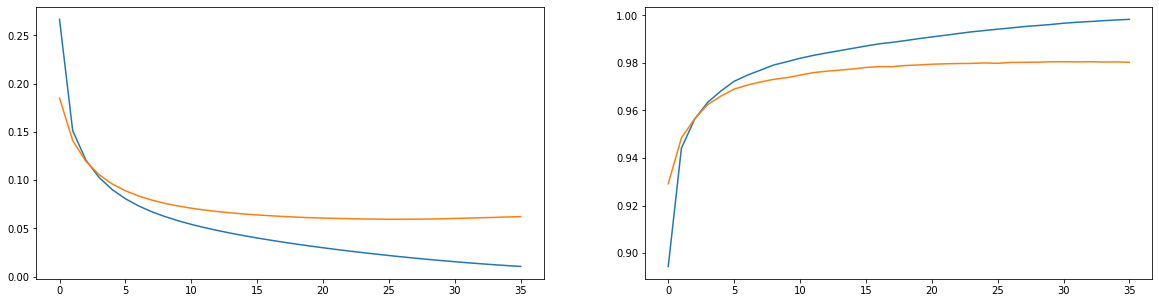

Epoch 37/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0100 - accuracy: 0.9985 - val_loss: 0.0626 - val_accuracy: 0.9804


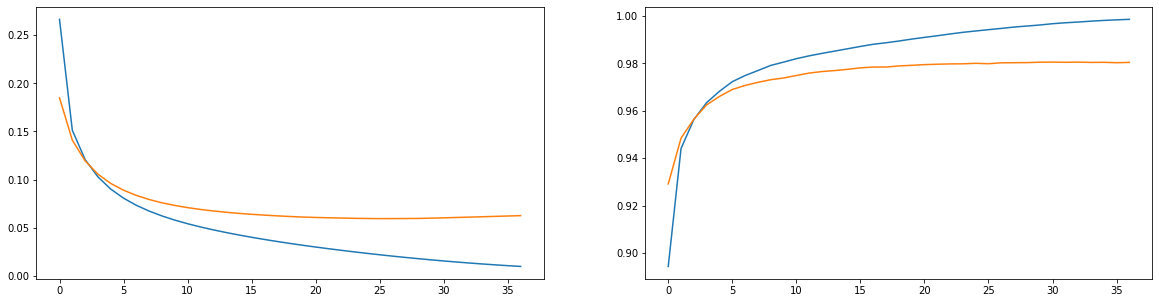

Epoch 38/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0092 - accuracy: 0.9986 - val_loss: 0.0631 - val_accuracy: 0.9804


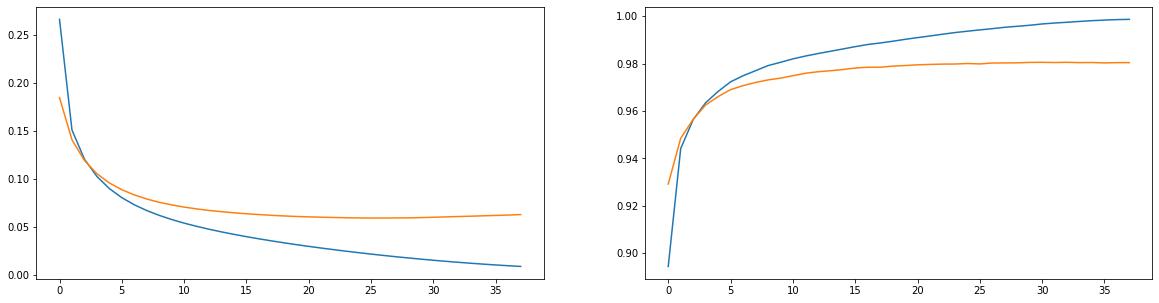

Epoch 39/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0085 - accuracy: 0.9988 - val_loss: 0.0635 - val_accuracy: 0.9806


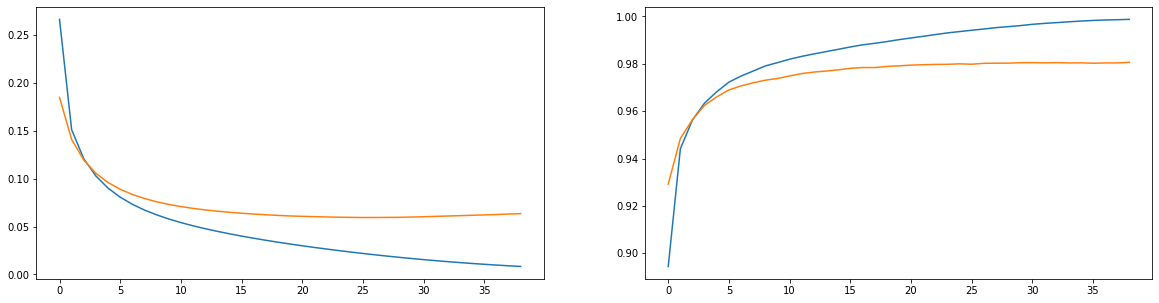

Epoch 40/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0079 - accuracy: 0.9989 - val_loss: 0.0640 - val_accuracy: 0.9808


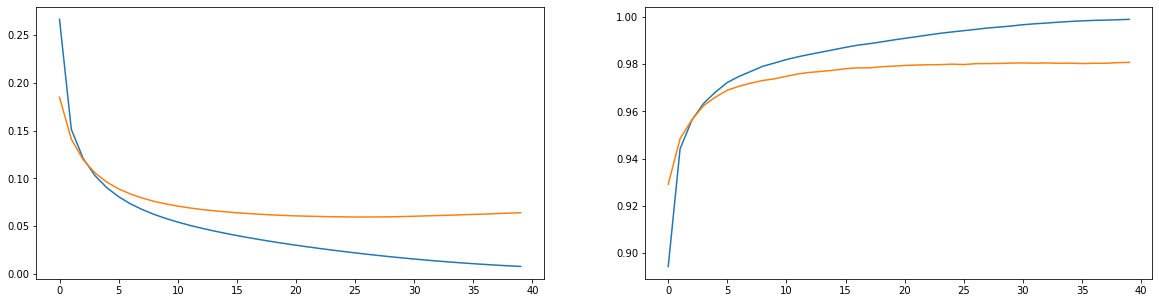

Epoch 41/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0073 - accuracy: 0.9991 - val_loss: 0.0645 - val_accuracy: 0.9809


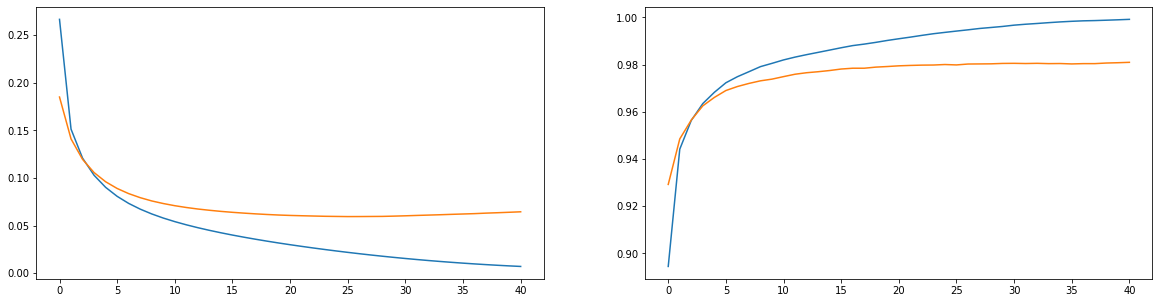

Epoch 42/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0067 - accuracy: 0.9992 - val_loss: 0.0651 - val_accuracy: 0.9808


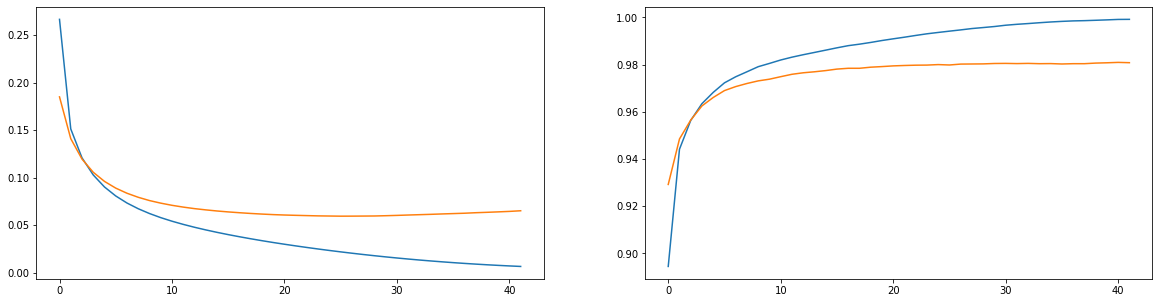

Epoch 43/50
2950/2950 [==============================] - 67s 23ms/step - loss: 0.0062 - accuracy: 0.9993 - val_loss: 0.0658 - val_accuracy: 0.9811


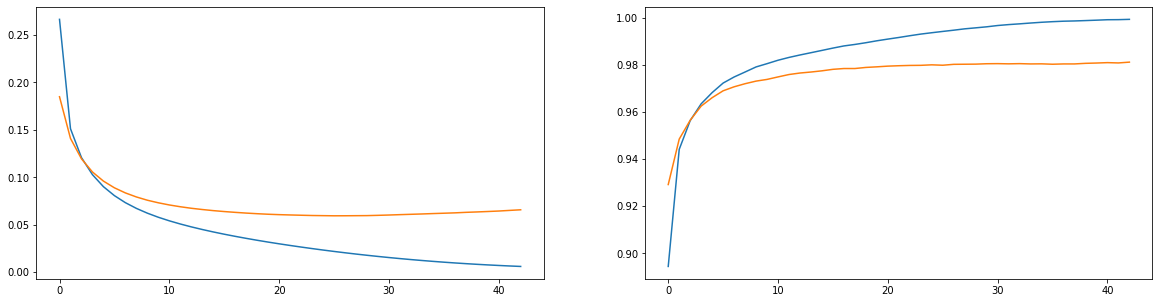

Epoch 44/50
2950/2950 [==============================] - 67s 23ms/step - loss: 0.0057 - accuracy: 0.9994 - val_loss: 0.0663 - val_accuracy: 0.9813


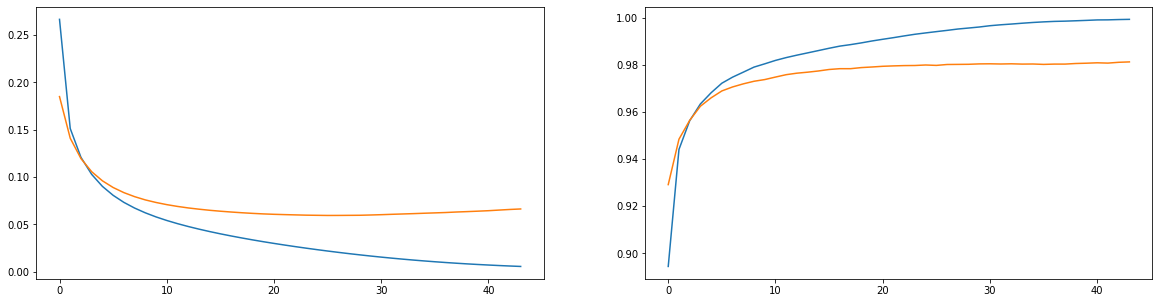

Epoch 45/50
2950/2950 [==============================] - 67s 23ms/step - loss: 0.0053 - accuracy: 0.9994 - val_loss: 0.0669 - val_accuracy: 0.9814


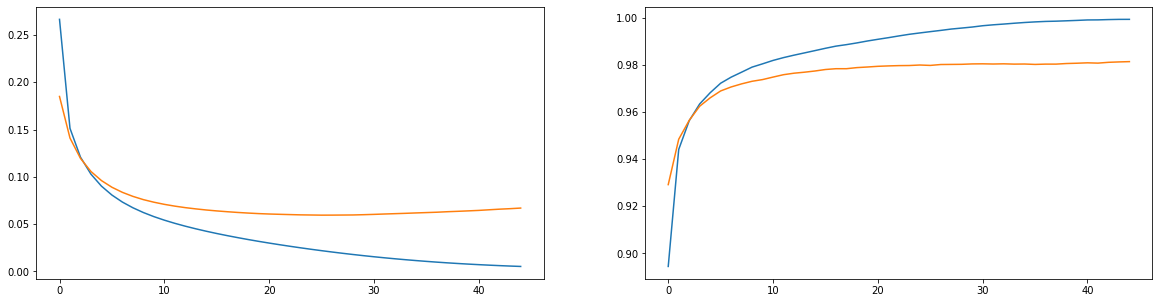

Epoch 46/50
2950/2950 [==============================] - 67s 23ms/step - loss: 0.0049 - accuracy: 0.9995 - val_loss: 0.0677 - val_accuracy: 0.9814


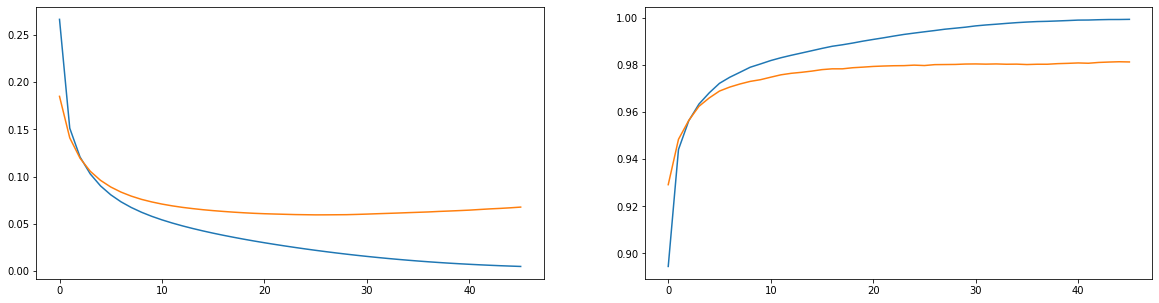

Epoch 47/50
2950/2950 [==============================] - 66s 22ms/step - loss: 0.0045 - accuracy: 0.9996 - val_loss: 0.0683 - val_accuracy: 0.9815


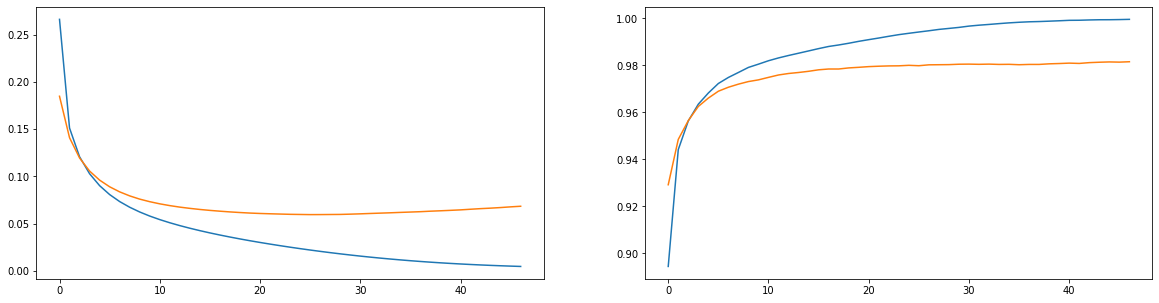

Epoch 48/50
2950/2950 [==============================] - 66s 23ms/step - loss: 0.0042 - accuracy: 0.9996 - val_loss: 0.0691 - val_accuracy: 0.9818


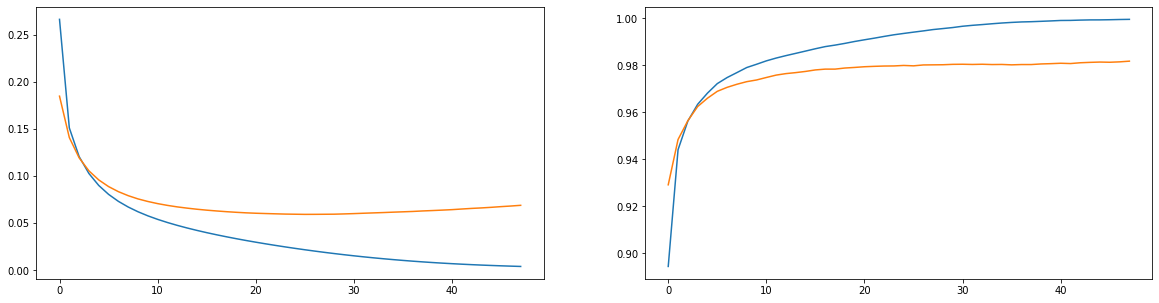

Epoch 49/50
2950/2950 [==============================] - 67s 23ms/step - loss: 0.0039 - accuracy: 0.9997 - val_loss: 0.0700 - val_accuracy: 0.9816


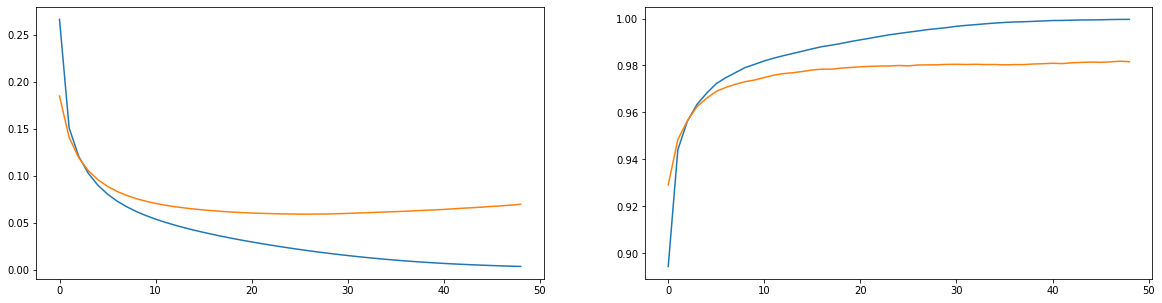

Epoch 50/50
2950/2950 [==============================] - 66s 23ms/step - loss: 0.0036 - accuracy: 0.9997 - val_loss: 0.0705 - val_accuracy: 0.9817


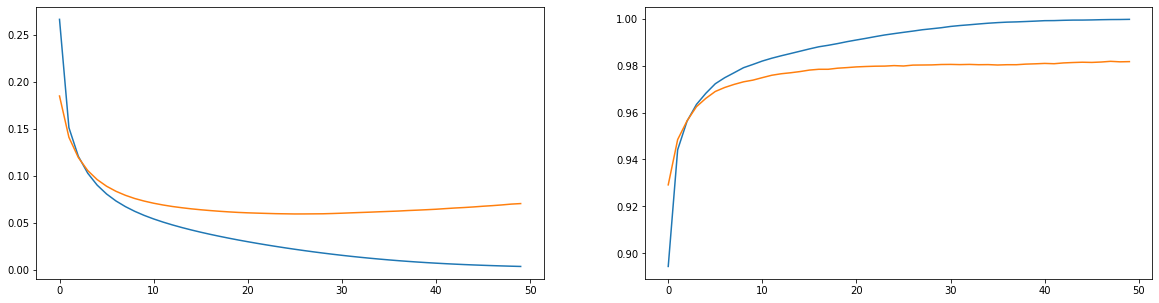

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

callbacks = real_time_callback()

history = model.fit(dataset_train_batched, epochs=50, shuffle=True, validation_data=dataset_test_batched, callbacks=[callbacks])

In [ ]:
test_loss, test_acc = model.evaluate(dataset_test_prof_x, dataset_test_prof_y)
print("Test Accuracy : ", test_acc)
print("Test Loss     : ", test_loss)

RuntimeError: ignored

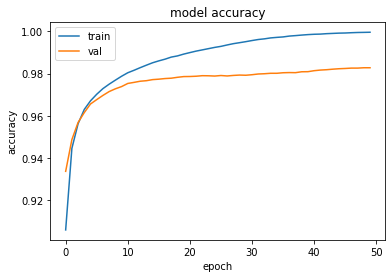

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

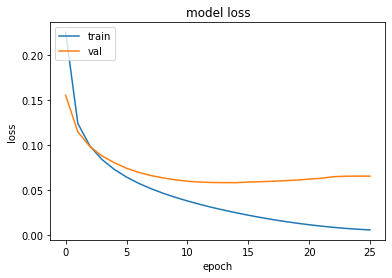

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('keras_model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

model_size = len(tflite_model) / 1024
print("Size : %dKBs" % model_size)

file = open('model.tflite', 'wb')
file.write(tflite_model)
file.close()
print("Model Saved.")

INFO:tensorflow:Assets written to: /tmp/tmpo6d1ar30/assets


INFO:tensorflow:Assets written to: /tmp/tmpo6d1ar30/assets


Size : 4262KBs
Model Saved.


In [ ]:
files.download('model.tflite')
files.download('keras_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

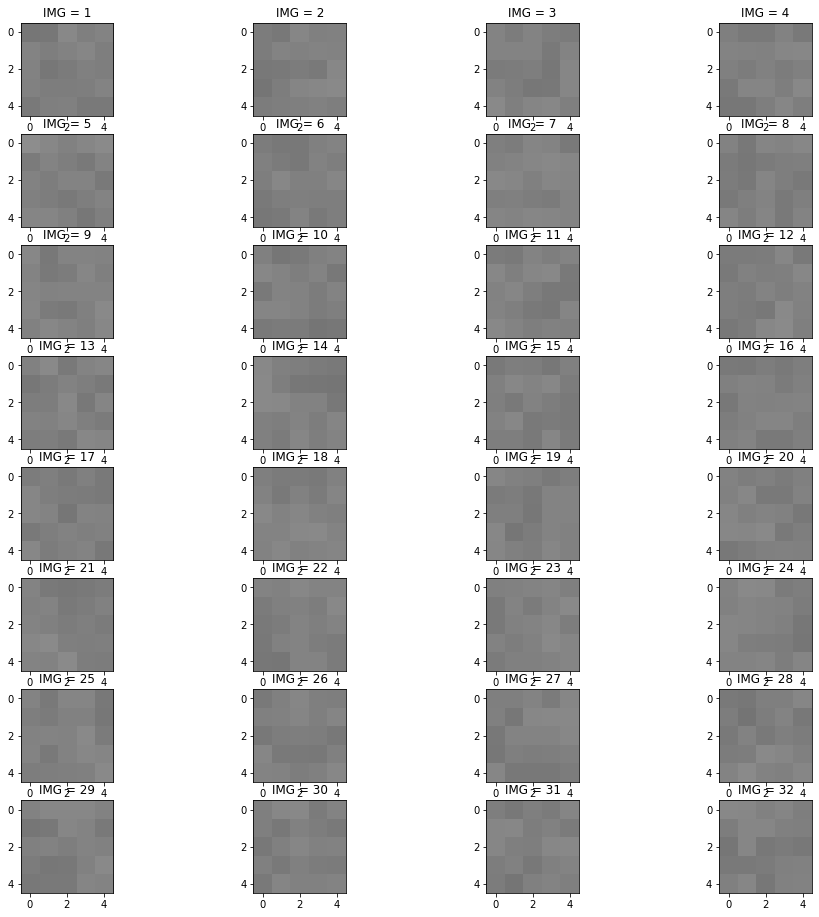

In [ ]:
def show_samples():
  fig = plt.figure(figsize=(16,16))
  columns = 4
  rows = 8
  for i in  range(1, columns * rows + 1):
    img = model.trainable_variables[0].read_value().numpy().take(i - 1, axis=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(img), cmap='gray',  vmin=-1, vmax=1)
    plt.title('IMG = ' +  str(i))
  plt.show()
show_samples()

In [ ]:
labels = model.predict(dataset_test_prof_x)
print(labels)
res = [int(x.argmax(axis=0) == dataset_test_prof_y[i]) for i,x in enumerate(labels)]
print(sum(res)/len(res))

[[2.2207482e-03 9.9996436e-01]
 [4.5533419e-01 8.6230993e-01]
 [9.6223909e-01 8.1636813e-03]
 [1.6827098e-01 8.6295056e-01]
 [9.9964023e-01 1.7247251e-03]
 [9.4249916e-01 4.6785533e-01]
 [4.5448483e-06 9.9999118e-01]
 [2.7910834e-03 9.9933773e-01]
 [1.3845460e-01 9.7533071e-01]
 [9.2572325e-01 5.9720486e-01]
 [2.9664002e-03 9.9515909e-01]
 [3.0995959e-01 8.7730420e-01]
 [1.4219850e-07 9.9999964e-01]
 [2.0240908e-02 9.9843913e-01]
 [1.7833264e-01 9.1703248e-01]
 [9.9761742e-01 1.4709010e-02]
 [1.0491993e-03 9.9696463e-01]
 [9.9836737e-01 7.2716530e-03]
 [1.5910880e-03 9.8962736e-01]
 [4.9394161e-02 9.9124861e-01]
 [9.4376332e-01 4.8013989e-02]
 [5.4702435e-02 9.9111533e-01]
 [9.9828148e-01 3.2352842e-02]
 [5.6356519e-05 9.9995220e-01]
 [8.9099163e-01 3.7153002e-02]
 [9.9503350e-01 7.4015288e-03]
 [1.1468351e-01 9.6111315e-01]
 [7.5616849e-06 9.9996889e-01]
 [9.9903393e-01 5.7401494e-03]
 [9.9942797e-01 2.2269038e-03]
 [9.9779630e-01 3.4385987e-03]
 [9.9781054e-01 3.5398446e-02]
 [4.0302

In [ ]:
PATH = os.path.join(os.getcwd(), 'model_vars')

if not os.path.isdir(PATH) :
  os.mkdir(PATH)

# Save filtyers to numpy arrays
for vars in model.trainable_variables:
  var_ids = vars.name.split(':')[0].replace('/','~')
  np.save(os.path.join( PATH, var_ids + '.npy'), vars.read_value().numpy())
shutil.make_archive('model_vars', 'zip', PATH)

'/content/model_vars.zip'